<a href="https://colab.research.google.com/github/jbernasconif/TextMining/blob/main/Practico2a_Word_Embeddings_Terminado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctico 2: Word Embeddings**
Prof. Carlos Toro, 2025

carlos.toro.ing@gmail.com

Nombre de Estudiante(s):

Juan Jose Bernasconi

#**1. Introducción**

Vimos en clases que es importante poder encontrar una representación de las palabras u oraciones en un formato numérico que nuestros modelos de machine learning puedan usar. Estas transformaciones de texto a vectores numéricos o embeddings las podemos hacer con modelos de diferente tipo, entre estos:

<figure>
<center>
<img src='https://media.geeksforgeeks.org/wp-content/uploads/20250530170636672412/Techniques-in-Embeddings-in-NLP.webp' />
<figcaption>Técnicas de Word Embeddings</figcaption></center>
</figure>

[Fuente](https://www.geeksforgeeks.org/nlp/word-embeddings-in-nlp/)

El objetivo de este práctico es revisar algunas de estas técnicas, generar algunas visualizaciones y entrenar algunos modelos de machine learning para resolver tareas como la clasificación de texto. Usaremos además algunas bibliotecas de Python disponibles y modelos pre-entrenados para facilitar algunas tareas. En las siguientes clases nos ocuparemos de trabajar con modelos de lenguaje mas grandes como ELMO, BERT y GPT, en esta solo trabajaremos con aproximaciones tradicionales.

**Algunos imports necesarios para el práctico:**

Antes, instalamos Gensim, una biblioteca de Python para el modelado de temas, la indexación de documentos y la recuperación de similitudes con grandes corpus. Está dirigida a la comunidad de procesamiento del lenguaje natural (PLN) y recuperación de información (IR).

In [1]:
%pip install gensim

In [2]:
import gdown
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from gensim.models.keyedvectors import KeyedVectors

import nltk
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from bs4 import BeautifulSoup
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#**2. Algunas técnicas tradicionales de Word Embeddings**

##**A) Bag of Words (BoW)**

Es el método más simple. Representa un documento contando la frecuencia de cada palabra de un vocabulario global. Ignora por completo el orden y la gramática.

In [3]:
corpus = [
    'un perro es un animal doméstico',
    'un gato es otro animal doméstico',
    'el software de python es una herramienta de tecnología',
    'el software python ayuda a cualquier animal a programar'
]
vectorizer = CountVectorizer(stop_words=['un','una', 'es', 'de', 'a', 'el', 'la', 'otro', 'cualquier'])
X = vectorizer.fit_transform(corpus)

# Visualizar como una matriz densa
df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(df_bow)


   animal  ayuda  doméstico  gato  herramienta  perro  programar  python  \
0       1      0          1     0            0      1          0       0   
1       1      0          1     1            0      0          0       0   
2       0      0          0     0            1      0          0       1   
3       1      1          0     0            0      0          1       1   

   software  tecnología  
0         0           0  
1         0           0  
2         1           1  
3         1           0  


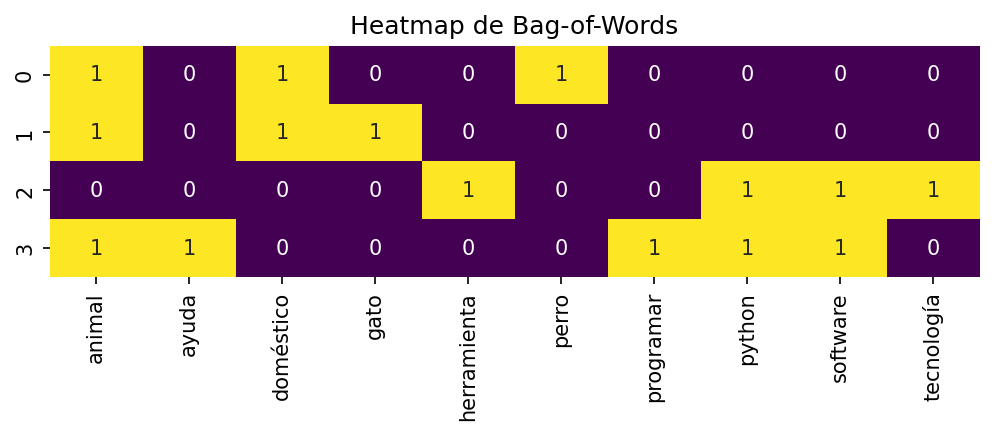

In [4]:
plt.figure(figsize=(8,2),dpi=150)
sns.heatmap(df_bow, annot=True, cbar = False, cmap='viridis').set_title('Heatmap de Bag-of-Words')
plt.show()

Otra forma es usar CountVectorizer para encontrar una representación que solo indique un 1 si la palabra se encuentra en el documento o frase (no importa cuántas veces aparezca) y 0 si la palabra  no se encuentra. Esto sería una codificación 'one-hot'.

In [5]:
one_hot_vectorizer = CountVectorizer(binary=True,stop_words=['un','una', 'es', 'de', 'a', 'el', 'la', 'otro', 'cualquier'])
one_hot = one_hot_vectorizer.fit_transform(corpus)
df_one_hot = pd.DataFrame(one_hot.toarray(), columns=one_hot_vectorizer.get_feature_names_out())
print(df_one_hot)

   animal  ayuda  doméstico  gato  herramienta  perro  programar  python  \
0       1      0          1     0            0      1          0       0   
1       1      0          1     1            0      0          0       0   
2       0      0          0     0            1      0          0       1   
3       1      1          0     0            0      0          1       1   

   software  tecnología  
0         0           0  
1         0           0  
2         1           1  
3         1           0  


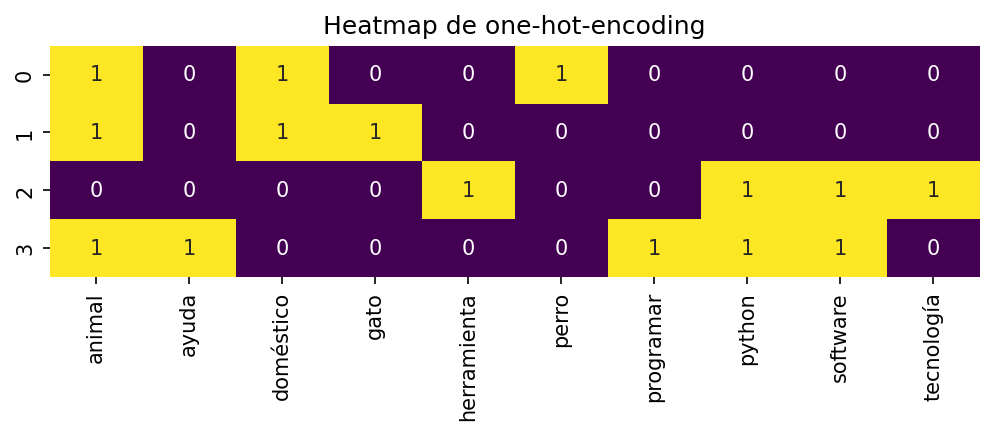

In [6]:
plt.figure(figsize=(8,2),dpi=150)
sns.heatmap(df_one_hot, annot=True, cbar = False, cmap='viridis').set_title('Heatmap de one-hot-encoding')
plt.show()

##**B) TF-IDF (Term Frequency-Inverse Document Frequency)**

Mejora a BoW. Pondera las palabras no solo por su frecuencia en un documento (TF), sino también por su rareza en todo el corpus (IDF). Las palabras comunes como "el" o "de" reciben un peso bajo, mientras que las palabras temáticamente importantes reciben un peso alto.

In [7]:
tfidf_vectorizer = TfidfVectorizer(stop_words=['un','una', 'es', 'de', 'a', 'el', 'la', 'otro', 'cualquier'])
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(df_tfidf.round(2))


   animal  ayuda  doméstico  gato  herramienta  perro  programar  python  \
0    0.45   0.00       0.55   0.0         0.00    0.7       0.00    0.00   
1    0.45   0.00       0.55   0.7         0.00    0.0       0.00    0.00   
2    0.00   0.00       0.00   0.0         0.56    0.0       0.00    0.44   
3    0.33   0.52       0.00   0.0         0.00    0.0       0.52    0.41   

   software  tecnología  
0      0.00        0.00  
1      0.00        0.00  
2      0.44        0.56  
3      0.41        0.00  


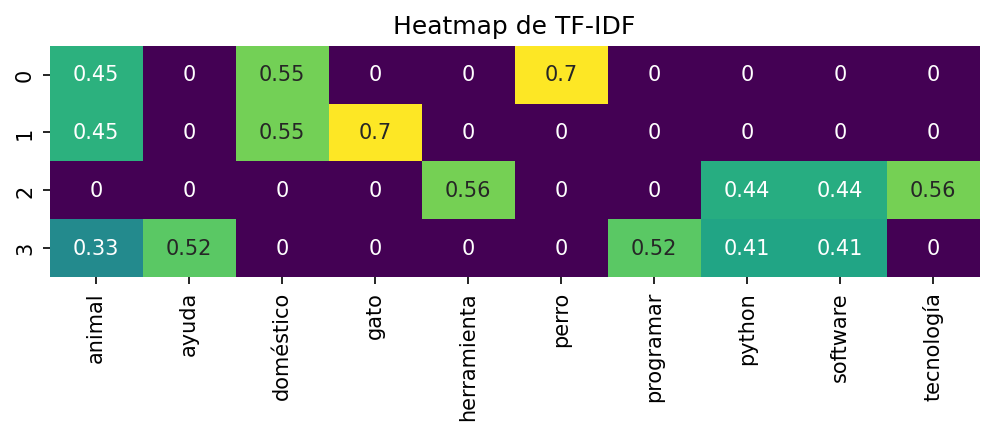

In [8]:
plt.figure(figsize=(8,2),dpi=150)
sns.heatmap(df_tfidf, annot=True,cbar = False, cmap='viridis').set_title('Heatmap de TF-IDF')
plt.show()


## **C) Word2Vec**  

Aprende los embeddings prediciendo palabras a partir de su contexto (modelo CBOW) o prediciendo el contexto a partir de una palabra (modelo Skip-Gram). Famoso por capturar analogías semánticas (ej. rey - hombre + mujer ≈ reina).

## **Descarguemos un Word2Vec pre-entrenado**

El archivo GoogleNews-vectors-negative300.bin es un modelo de embeddings de palabras ampliamente utilizado, fue desarrollado por Google. Este archivo binario contiene una colección de vectores de palabras, cada uno de los cuales representa una palabra o frase como un vector numérico en un espacio de 300 dimensiones. Estos vectores de palabras se entrenaron con un corpus masivo de artículos de noticias y texto web, lo que les permite capturar el significado semántico y las relaciones entre las palabras.

[Archivo original desde Kaggle](https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300?resource=download&select=GoogleNews-vectors-negative300.bin.gz)

In [9]:
url = 'https://drive.google.com/uc?id=1FUUvxybphkvKzLIvVQ2Ra8u-MI3dVIMA'
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1FUUvxybphkvKzLIvVQ2Ra8u-MI3dVIMA
From (redirected): https://drive.google.com/uc?id=1FUUvxybphkvKzLIvVQ2Ra8u-MI3dVIMA&confirm=t&uuid=a903bc69-173a-40dd-9cd5-390a025a9da1
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:06<00:00, 252MB/s]


'GoogleNews-vectors-negative300.bin.gz'

In [10]:
goog_wordvecs = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=100000)#limitamos el tamaño para trabajar

In [11]:
goog_wordvecs.vectors.shape

(100000, 300)

#**3. Curiosidades con los Embeddings**

## **A) Analogías con Word2vec**
###**Álgebra de vectores con interpretación semántica**

Inspirado y basado en: https://github.com/dccuchile/spanish-word-embeddings/blob/master/examples/Ejemplo_WordVectors.ipynb

**Ejemplo de uso:**` most_similar_cosmul(positive=lista_palabras_positivas, negative=lista_palabras_negativas)`

Esta llamada encuentra las palabras del vocabulario que están más cercanas a las palabras en listas_palabras_positivas y no estén cercanas a lista_palabras_negativas (para una formalización del procedimiento, ver la fórmula (4) en la Sección 6 de este [artículo](http://www.aclweb.org/anthology/W14-1618)).

Cuando lista_palabras_positivas contiene dos palabras, digamos a y b_p, y lista_palabras_negativas contiene una palabra, digamos a_p, el procedimiento anterior se lee coloquialmente como el encontrar la palabra b que responde a la pregunta: a_p es a a como b_p es a ???. El ejemplo clásico se tiene cuando a es rey, b_p es mujer, y a_p es hombre. La palabra buscada b es reina, pues hombre es a rey como mujer es a reina.

In [12]:
goog_wordvecs.most_similar_cosmul(positive=['woman','king'],negative=['queen'])

[('man', 0.9307777285575867),
 ('boy', 0.8291134238243103),
 ('motorcyclist', 0.7735416293144226),
 ('teenage_girl', 0.7693272233009338),
 ('teenager', 0.7692983746528625),
 ('taxi_driver', 0.7674799561500549),
 ('girl', 0.7596036195755005),
 ('victim', 0.7527119517326355),
 ('bicyclist', 0.7488752603530884),
 ('father', 0.7468025088310242)]

In [13]:
goog_wordvecs.most_similar_cosmul(positive=['actor','woman'],negative=['man'])

[('actress', 1.0588080883026123),
 ('actresses', 0.9304280281066895),
 ('Best_Actress', 0.8946203589439392),
 ('Actress', 0.8936436772346497),
 ('comedienne', 0.8506139516830444),
 ('Best_Supporting_Actress', 0.8503092527389526),
 ('actors', 0.8433448076248169),
 ('Paltrow', 0.8427857160568237),
 ('Heigl', 0.8372300267219543),
 ('Golden_Globe', 0.8350875973701477)]

In [14]:
goog_wordvecs.most_similar_cosmul(positive=['son','woman'],negative=['man'])

[('daughter', 1.053764820098877),
 ('mother', 1.0130525827407837),
 ('niece', 0.9732571840286255),
 ('eldest_daughter', 0.9666094779968262),
 ('granddaughter', 0.95781010389328),
 ('husband', 0.956787109375),
 ('daughters', 0.9557827115058899),
 ('sister', 0.9450976252555847),
 ('father', 0.9181194305419922),
 ('wife', 0.9142286777496338)]

In [15]:
goog_wordvecs.most_similar_cosmul(positive=['play','singing'],negative=['sing'])

[('playing', 0.9153854846954346),
 ('played', 0.8183861374855042),
 ('game', 0.8155624866485596),
 ('plays', 0.8033236861228943),
 ('Playing', 0.7878930568695068),
 ('games', 0.7651411294937134),
 ('scoring', 0.7445952892303467),
 ('physicality', 0.7320943474769592),
 ('Play', 0.728746771812439),
 ('playmaking', 0.7280517220497131)]

In [16]:
goog_wordvecs.most_similar_cosmul(positive=['Santiago','Venezuela'],negative=['Chile'])

[('Caracas', 0.9518518447875977),
 ('Ramírez', 0.9386518597602844),
 ('Peña', 0.9186561703681946),
 ('Chavez', 0.9147828221321106),
 ('Rodríguez', 0.9133160710334778),
 ('Martinez', 0.9109025001525879),
 ('Ramirez', 0.9093917608261108),
 ('Ortiz', 0.9087135791778564),
 ('Venezuelan', 0.9070562124252319),
 ('Martínez', 0.9041159749031067)]

In [17]:
goog_wordvecs.most_similar_cosmul(positive=['Buenos_Aires','Chile'],negative=['Santiago'])

[('Argentina', 1.0106027126312256),
 ('Brazil', 0.9226211905479431),
 ('Uruguay', 0.8886619210243225),
 ('Chilean', 0.8861171007156372),
 ('Argentine', 0.879367470741272),
 ('Argentines', 0.8666806221008301),
 ('Peru', 0.8634063005447388),
 ('Paraguay', 0.863052248954773),
 ('Bolivia', 0.8587836623191833),
 ('President_Nestor_Kirchner', 0.8434462547302246)]

**Actividad 1**

Use su creatividad y encuentre al menos unos 3 ejemplos interesantes adicionales de analogías (hay 3 celdas en blanco abajo para ello, pero siéntase libre de agregar más si lo desea). Luego comente más abajo por qué escogió dichos ejemplos.

In [18]:
goog_wordvecs.most_similar_cosmul(positive=['Euro','Japan'],negative=['Germany'])

[('Yen', 0.8772328495979309),
 ('yen', 0.8675987720489502),
 ('JPY', 0.8584219217300415),
 ('Japanese', 0.8166151642799377),
 ('Japanese_Yen', 0.8161985278129578),
 ('Y###', 0.8096152544021606),
 ('USDJPY', 0.805469274520874),
 ('Nikkei', 0.7978377342224121),
 ('NZD', 0.7972946763038635),
 ('¥', 0.7949848175048828)]

In [19]:
goog_wordvecs.most_similar_cosmul(positive=['Paris','Germany'],negative=['France'])

[('Berlin', 0.9318029880523682),
 ('Frankfurt', 0.9193994402885437),
 ('Dusseldorf', 0.9009348750114441),
 ('Munich', 0.8798270225524902),
 ('Düsseldorf', 0.864493727684021),
 ('Cologne', 0.8547464609146118),
 ('Stuttgart', 0.8522416353225708),
 ('Budapest', 0.8519014120101929),
 ('Munich_Germany', 0.8492376208305359),
 ('Hamburg', 0.8413189649581909)]

In [20]:
goog_wordvecs.most_similar_cosmul(positive=['Madrid','Spain'],negative=['Chile'])

[('Barcelona', 1.1103788614273071),
 ('Catalan', 0.9941185712814331),
 ('Seville', 0.9773440361022949),
 ('Bilbao', 0.9608011841773987),
 ('Malaga', 0.9574896097183228),
 ('Catalonia', 0.95472252368927),
 ('Mallorca', 0.9513633847236633),
 ('Spaniards', 0.9435475468635559),
 ('Barca', 0.9427789449691772),
 ('Valencia', 0.9297207593917847)]

**Comente aquí los ejemplos:**

Intento de hacer combianaciones interesantes entre paises y ubicaciones geofracias para ver que sale

## **B) Word vectors en términos excluídos**

**Ejemplo de uso**: doesnt_match(lista_palabras)

Esta llamada selecciona la palabra dentro de listas_palabras que está más lejana del resto de las palabras de la lista. La distancia es simplemente el ángulo entre las direcciones de los vectores de las palabras.

In [21]:
goog_wordvecs.doesnt_match(['white','blue','red','Chile'])

'Chile'

In [22]:
goog_wordvecs.doesnt_match(['Sun','Moon','lunch','Jupiter'])

'lunch'

In [23]:
goog_wordvecs.doesnt_match(['April', 'May', 'September', 'Tuesday', 'July'])

'Tuesday'

In [24]:
goog_wordvecs.doesnt_match(['Monday', 'Tuesday', 'September', 'Thursday', 'Friday'])

'September'

In [25]:
goog_wordvecs.doesnt_match(['Lima', 'Paris', 'London', 'Madrid'])

'Lima'

**Actividad 2**

Use su creatividad y encuentre al menos unos 3 ejemplos interesantes adicionales de términos excluidos (hay 3 celdas en blanco abajo para ello, pero siéntase libre de agregar más si lo desea). Luego comente más abajo por qué escogió dichos ejemplos.

In [26]:
goog_wordvecs.doesnt_match(['Monday', 'Tuesday', 'September', 'Thursday', 'Friday'])

'September'

In [28]:
goog_wordvecs.doesnt_match(['white','blue','red','chile', 'germany'])

'USA'

In [34]:

goog_wordvecs.doesnt_match(['dog','cat','parrot','tiger', 'hamster'])

'tiger'

**Comente aquí los ejemplos:**

intnetar hacer combinaciones entre animales domesticos y libres, o colores de banderas y los paises a ver cual deja afuera




## **C) Visualizando Word Embeddings**

Proyectamos los word vectors a un plano 2D usando reducción de dimensionalidad con PCA:

In [35]:
vectors_2d = PCA(n_components=2).fit_transform(goog_wordvecs.vectors)

Recolectamos todas las palabras del vocabulario en una lista:

In [36]:
all_words = [None] * len(goog_wordvecs.key_to_index)
for k,v in goog_wordvecs.key_to_index.items():
  all_words[v] = k

In [37]:
#ejemplo de valore recolectados
all_words[100:104]

['company', 'any', 'team', 'against']

In [39]:
#@title Funciones útiles para generar scatter plots de word vectors con sus respectivas palabras en un plano 2D:
# Esta función escoge palabras del vocabulario de manera aleatoria
def plot_word_embeddings_2d_random(words, embeddings, n_samples):
  n = len(words)
  indices = random.sample(range(n), n_samples)
  X = [embeddings[i][0] for i in indices]
  Y = [embeddings[i][1] for i in indices]
  plt.figure(figsize=(15,9))
  plt.scatter(X, Y, linewidths=5, color='blue')
  plt.xlabel("PC1",size=15)
  plt.ylabel("PC2",size=15)
  plt.title("Word Embedding Space", size=20)
  for i in range(n_samples):
    plt.annotate("  " + words[indices[i]], xy=(X[i],Y[i]))
  plt.show()

# Esta función recibe de forma explícita las palabras
def plot_word_embeddings_2d(words, key_to_index, embeddings):
  indices = [key_to_index[w] for w in words]
  X = [embeddings[i][0] for i in indices]
  Y = [embeddings[i][1] for i in indices]
  plt.figure(figsize=(15,9))
  plt.scatter(X, Y, linewidths=5, color='blue')
  plt.xlabel("PC1",size=15)
  plt.ylabel("PC2",size=15)
  plt.title("Word Embedding Space", size=20)
  for i, word in enumerate(words):
    plt.annotate("  " + word, xy=(X[i],Y[i]))
  plt.show()

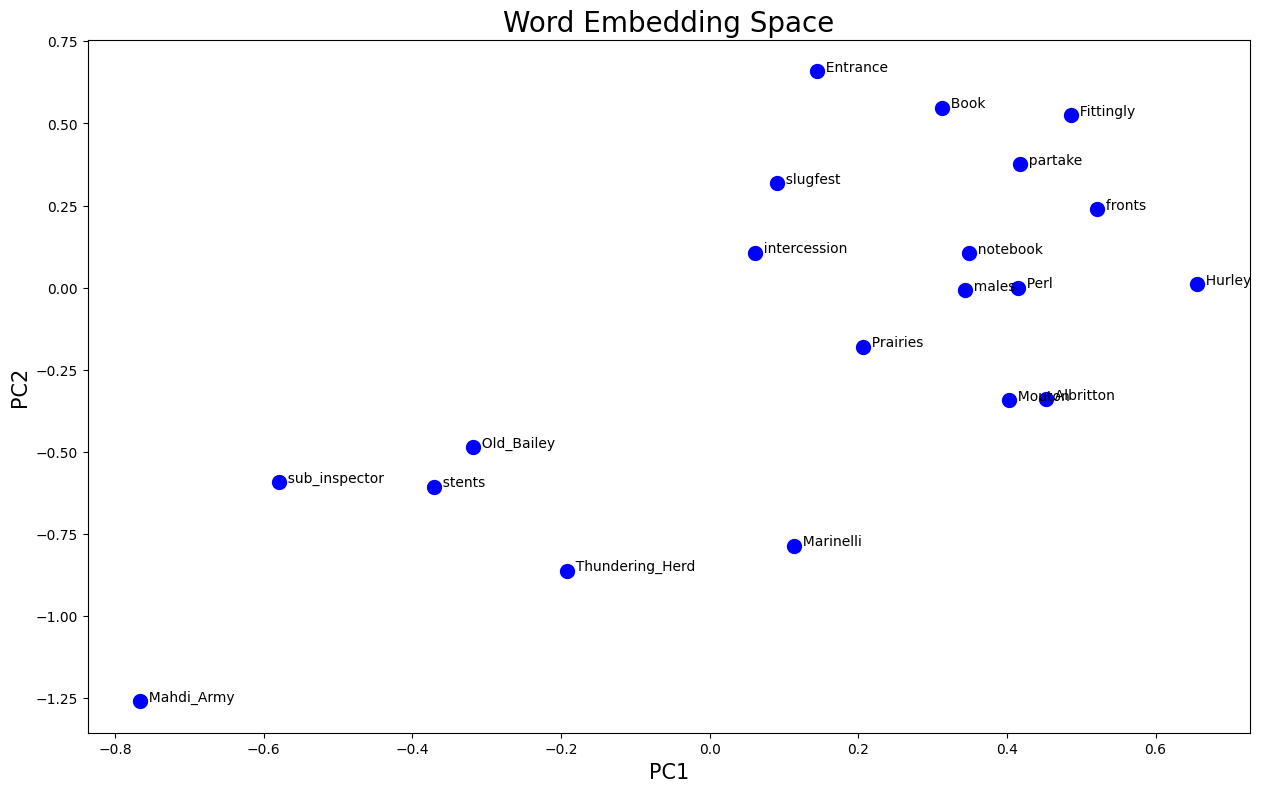

In [40]:
plot_word_embeddings_2d_random(all_words, vectors_2d, 20)

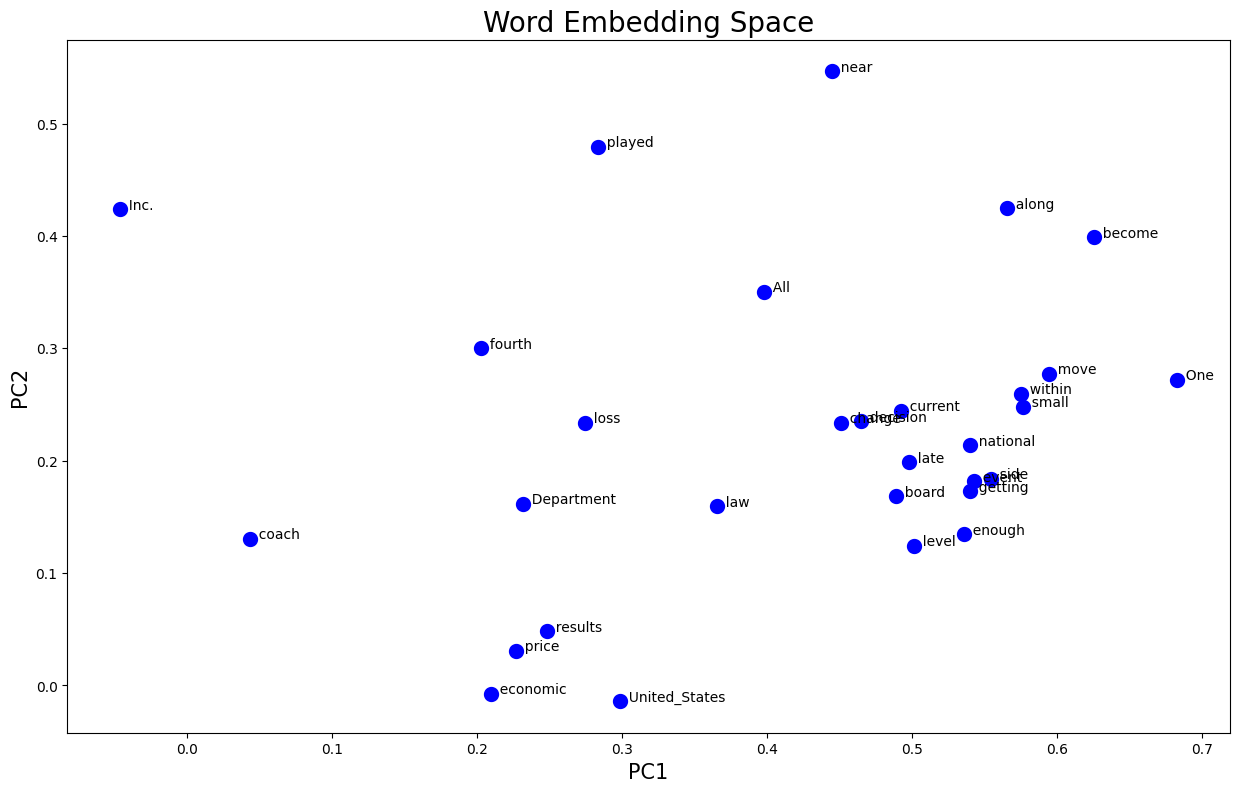

In [41]:
plot_word_embeddings_2d(all_words[400:430], goog_wordvecs.key_to_index, vectors_2d)

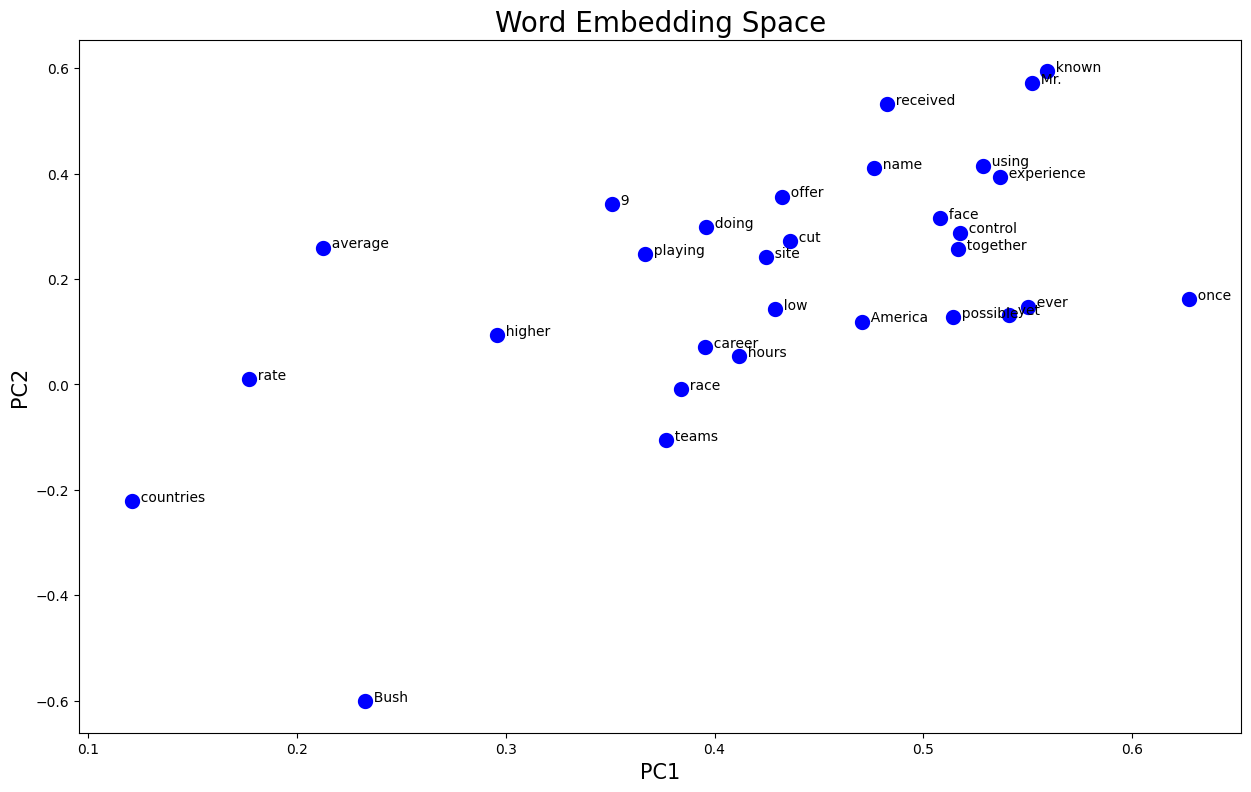

In [42]:
plot_word_embeddings_2d(all_words[500:530], goog_wordvecs.key_to_index, vectors_2d)

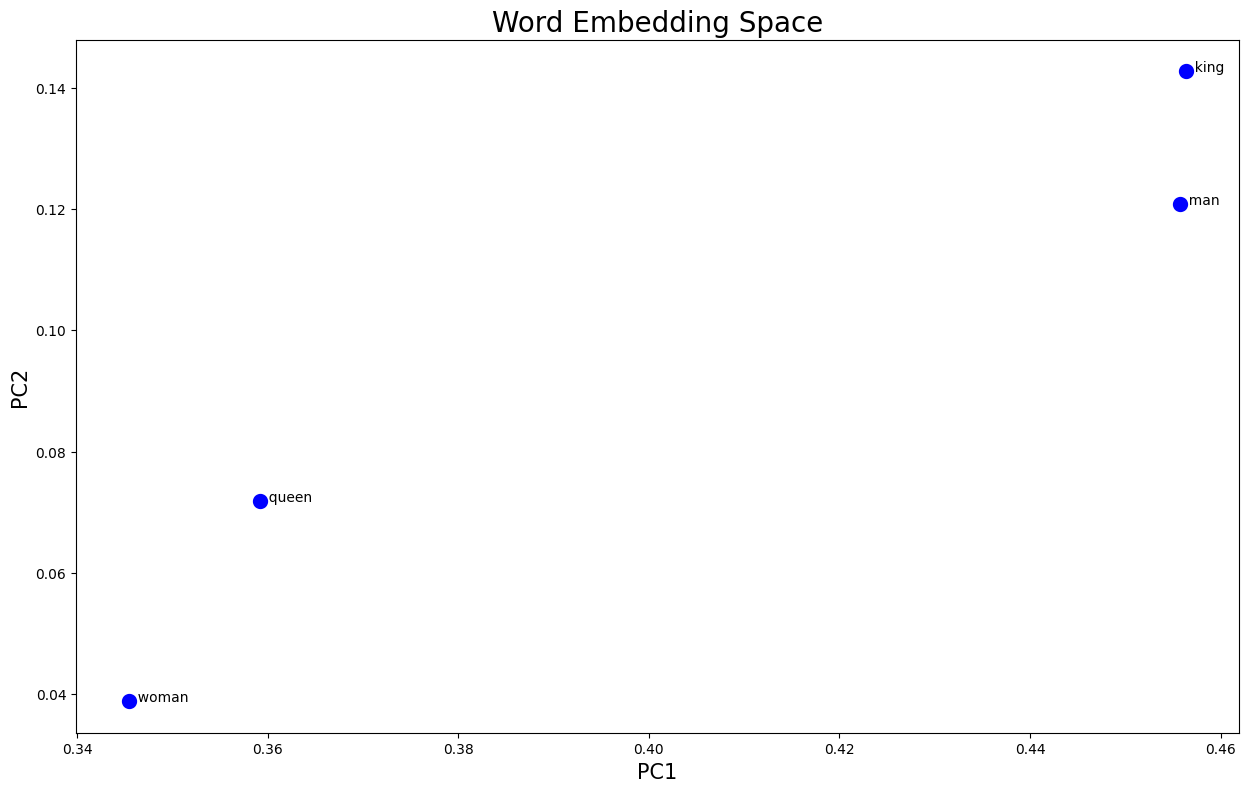

In [43]:
plot_word_embeddings_2d(["queen", "king", "woman", "man"],
                        goog_wordvecs.key_to_index, vectors_2d)

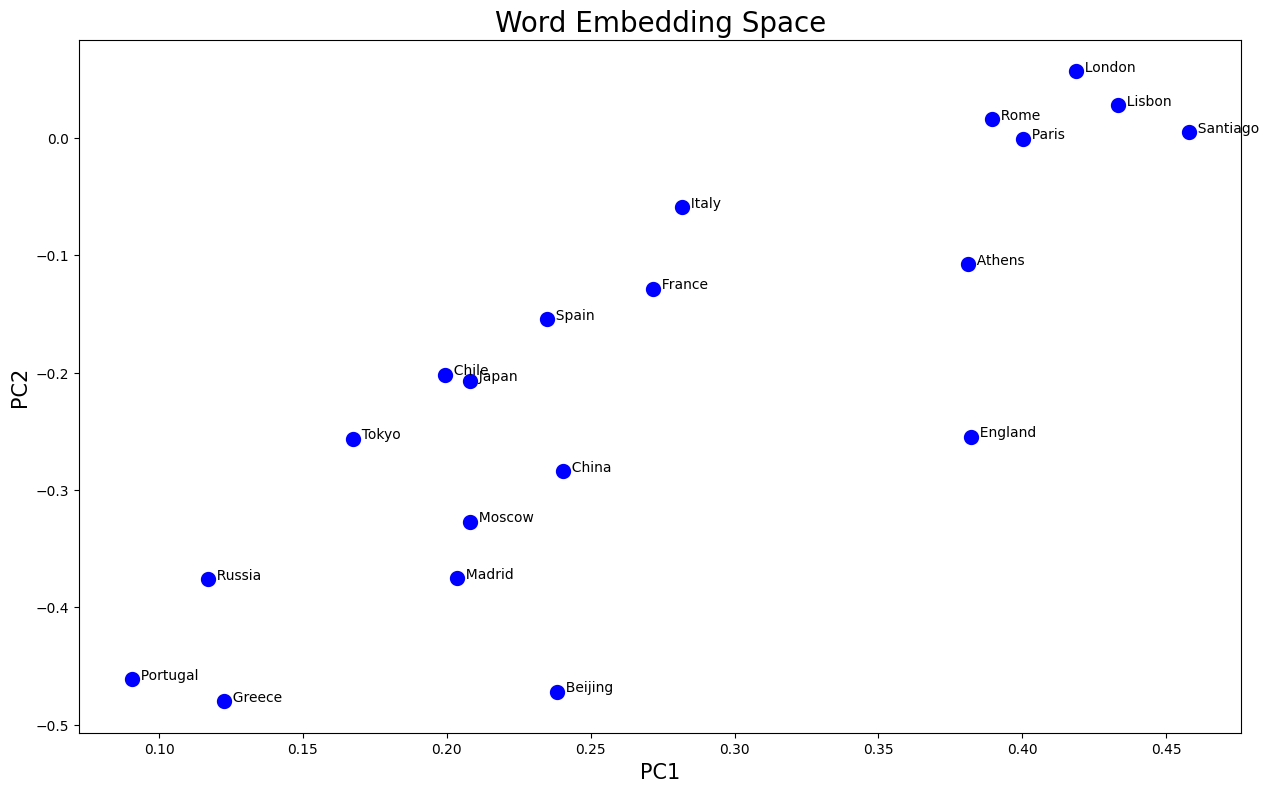

In [44]:
words = [
         "Chile", "Santiago",
         "England", "London",
         "France", "Paris",
         "China", "Beijing",
         "Russia", "Moscow",
         "Japan", "Tokyo",
         "Spain", "Madrid",
         "Portugal", "Lisbon",
         "Italy", "Rome",
         "Greece", "Athens",
         ]
plot_word_embeddings_2d(words, goog_wordvecs.key_to_index, vectors_2d)

**Actividad 3**


Use su creatividad y genere al menos unos 3 gráficos adicionales que le parezcan interesantes (hay 3 celdas en blanco abajo para ello, pero siéntase libre de agregar más si lo desea). Luego comente más abajo por qué escogió dichos gráficos.

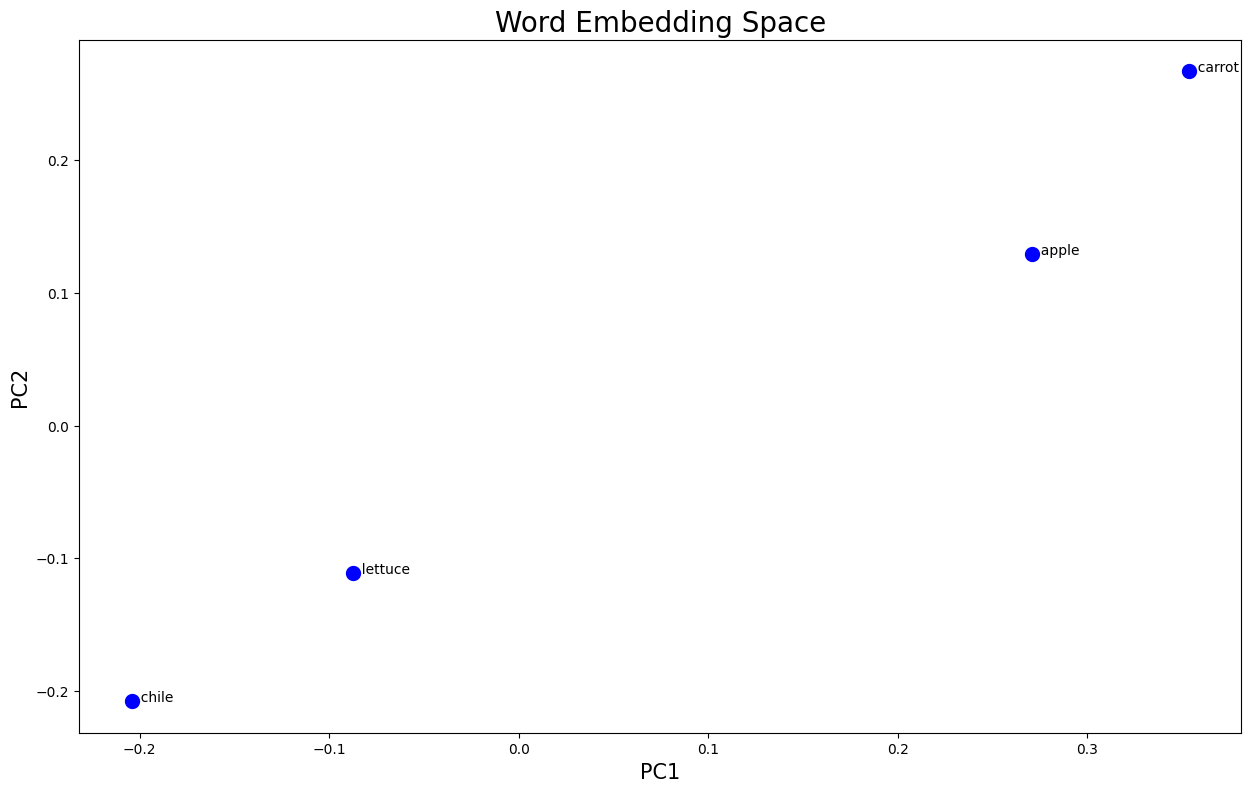

In [52]:
plot_word_embeddings_2d(["chile", "carrot", "lettuce", "apple"],
                        goog_wordvecs.key_to_index, vectors_2d)

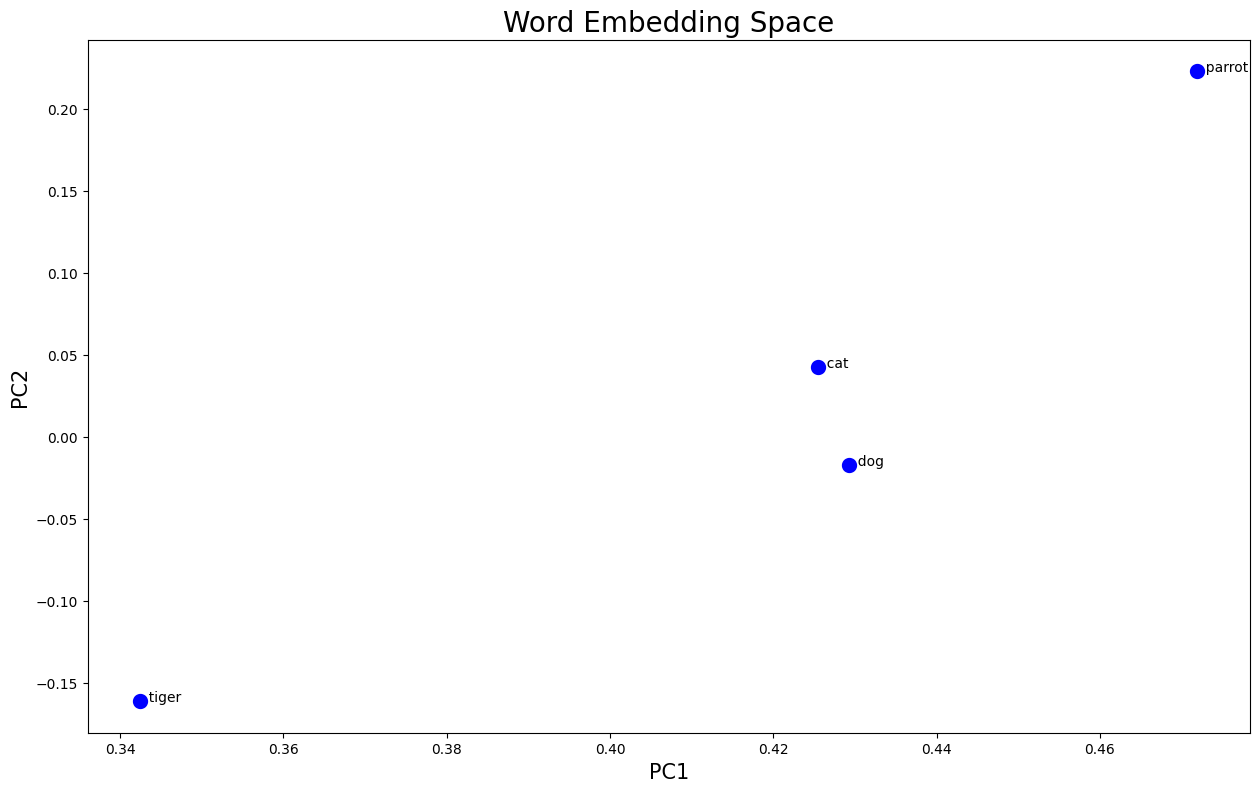

In [45]:
plot_word_embeddings_2d(["dog", "cat", "parrot", "tiger"],
                        goog_wordvecs.key_to_index, vectors_2d)

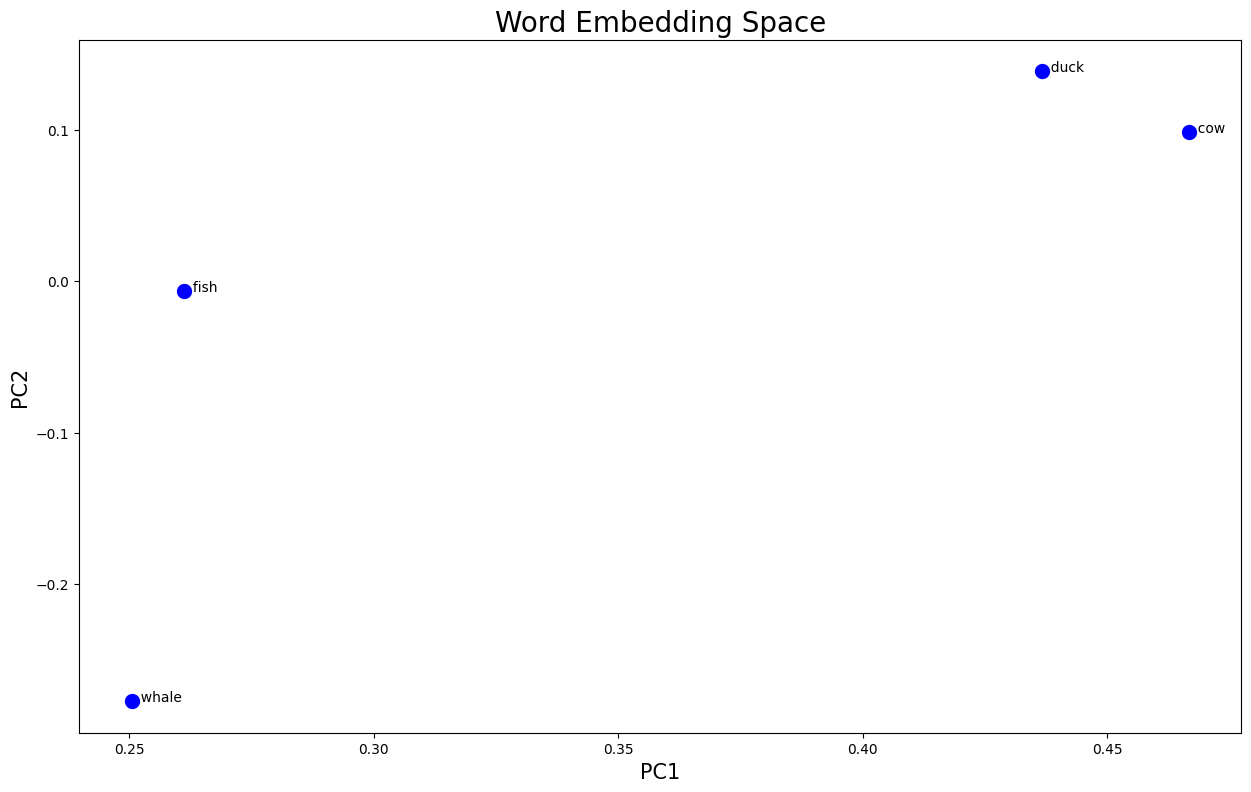

In [54]:
plot_word_embeddings_2d(["whale", "fish", "duck", "cow"],
                        goog_wordvecs.key_to_index, vectors_2d)

**Comente aquí sus gráficos**:

ejemplos que tengan que ver con cercania, entre animales domesticos, o entre peces y animales terrestres a ver que tan lejos o cercanos quedaba.

**Actividad 4**

Responda la siguiente pregunta:

**Pregunta**: ¿Cuál cree usted que sea la explicación de la propiedad de álgebra semántica demostrada por word embeddings como Word2vec? ¿A qué se debe que sumando y restando vectores podamos hacer analogías, detectar términos excluídos, entre otras cosas?

Esta pregunta no es sencilla, por lo que se le invita a investigar en internet y resumir en sus palabras lo que logre entender. Recuerde citar el material consultado.

**Respuesta**

Creo que la razón por la que podemos hacer sumas y restas con vectores en Word2Vec es porque el modelo organiza las palabras en un espacio donde las relaciones de significado se reflejan como direcciones. Por ejemplo, la diferencia entre "rey" y "hombre" es parecida a la de "reina" y "mujer", y eso se puede representar con vectores. Esto funciona porque Word2Vec aprende del contexto en que aparecen las palabras, y esas similitudes se terminan representando de forma matemática.

Fuente: Wikipedia - Word2Vec, Allen & Hospedales (2019) Analogies Explained.

# **Referencias:**



1.   [Rostyslav Neskorozhenyi, Word embeddings in 2020. Review with code examples](https://colab.research.google.com/drive/1N7HELWImK9xCYheyozVP3C_McbiRo1nb)
2.   [Word Embeddings in NLP](https://www.geeksforgeeks.org/nlp/word-embeddings-in-nlp/)
3. [Vader: A Comprehensive Guide to Sentiment Analysis in Python](https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e)

4. [Twitter Sentiment Analysis - word2vec, doc2vec](https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec)